# Code


# Imports

In [2]:
import pandas as pd
from pathlib import Path
import numpy as np
from typing import Optional, Tuple, Union
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from scipy.stats import ks_2samp, permutation_test
from joblib import Parallel, delayed
from tqdm import tqdm

# User Configuration

In [3]:
SAVE_FIG = True
SAVE_CSV = False  # Save figures

REAL_FILE = "20250301_data_20250510_122405_final_100_train.csv"
SYNTH_FILE = "20250301_data_20250510_122405_final_100_synth.csv"
HOLDOUT_FILE = "20250301_data_20250510_122405_final_100_holdout.csv"

N_BOOTSTRAP = 1000 # 500-1000
SAMPLE_SIZE = 5000 # 5% of Sample size
RANDOM_SEED = 42

DATA_DIR = Path("../../data")
OUTPUT_DIR_CSV = Path("results")
OUTPUT_DIR_CSV.mkdir(parents=True, exist_ok=True)  # ensure output folder exists
OUTPUT_DIR_FIG = Path("figures")
OUTPUT_DIR_FIG.mkdir(parents=True, exist_ok=True)  # ensure output folder exists

# Set my design
sns.set_theme(
    style="white",
    context="paper",
    palette="colorblind",
    rc={
        "font.family": "sans-serif",
        "font.sans-serif": ["Arial"],
        "font.size": 7,
        "axes.titlesize": 7,
        "axes.labelsize": 7,
        "xtick.labelsize": 7,
        "ytick.labelsize": 7,
        "legend.fontsize": 7
    }
)

# Utility Functions

## Load Data & Assign Correct Datatypes

In [4]:
def convert_dtypes(df: pd.DataFrame) -> pd.DataFrame:
    """
    Konvertiert bestimmte Spalten des DataFrames in die gewünschten Datentypen:
     - definierte Spalten als category
     - definierte Spalten als pandas Nullable Integer (Int64)
     - consciousness_level und news_score als geordnete Categoricals
    """
    df = df.copy()  # Änderungen nicht am Original vornehmen

    # 1) Kategorische Spalten
    cat_cols = ['gender', 'ethnicity', 'chief_complaint', 'icd_block']
    for col in cat_cols:
        df[col] = df[col].astype('category')

    # 2) Integer-Spalten mit Nullable Integer dtype
    int_cols = ['age', 'systolic_bp', 'diastolic_bp',
                'heart_rate', 'respiratory_rate', 'oxygen_saturation']
    for col in int_cols:
        df[col] = df[col].astype('Int64')

    # 3) Geordnete Categoricals
    df['consciousness_level'] = pd.Categorical(
        df['consciousness_level'],
        categories=['A', 'C', 'V', 'P', 'U'],
        ordered=True
    )
    df['news_score'] = pd.Categorical(
        df['news_score'],
        categories=list(range(19)),
        ordered=True
    )

    return df

def load_data(
    real_filename: Union[str, Path],
    synth_filename: Optional[Union[str, Path]] = None,
    holdout_filename: Optional[Union[str, Path]] = None,
    data_dir: Path = DATA_DIR
) -> Tuple[pd.DataFrame, Optional[pd.DataFrame], Optional[pd.DataFrame]]:
    """
    Lädt die realen, synthetischen und optionalen Holdout-CSV-Dateien
    aus data_dir und wandelt sie über convert_dtypes um.

    Returns:
        df_real: pd.DataFrame
        df_synth: Optional[pd.DataFrame]
        df_holdout: Optional[pd.DataFrame]
    """
    def _read_and_convert(fn: Union[str, Path]) -> pd.DataFrame:
        return (
            pd.read_csv(data_dir / fn, low_memory=False)
              .pipe(convert_dtypes)
        )

    df_real    = _read_and_convert(real_filename)
    df_synth   = _read_and_convert(synth_filename)   if synth_filename   else None
    df_holdout = _read_and_convert(holdout_filename) if holdout_filename else None

    return df_real, df_synth, df_holdout

## Own KS-Test Implementation

In [5]:
def tvd_statistic(x, y) -> float:
    """
    Total Variation Distance (diskret) zwischen x und y
    (0.5 * L1-Distanz der relativen Häufigkeiten).
    """
    X, Y = Counter(x), Counter(y)
    all_keys = set(X) | set(Y)
    n_x, n_y = len(x), len(y)
    return 0.5 * sum(
        abs(X[k]/n_x - Y[k]/n_y)
        for k in all_keys
    )

# def permutation_test_tvd(x, y, n_perms=1000):
#     """Returns (statistic, pvalue) via Permutationstest auf TVD."""
#     res = permutation_test(
#         (x, y),
#         tvd_statistic,
#         n_resamples=n_perms,
#         vectorized=False,
#         permutation_type='independent',
#         alternative='greater'
#     )
#     return res.statistic, res.pvalue



In [6]:
def bootstrap_ks_parallel(
    df_real: pd.DataFrame,
    df_synth: pd.DataFrame,
    cat_cols: list[str],
    n_bootstrap: int = 1000,
    n_sample_size: int | None = None,
    n_jobs: int = -1,
    random_state: int | None = None
) -> pd.DataFrame:
    """
    Paralleler Bootstrap für verschiedene Statistiken:
      - für jede kontinuierliche Spalte (nicht in cat_cols) KS-Statistik
      - für jede kategoriale Spalte TVD-Statistik
    stat_funcs kann benutzt werden, um weitere custom stats hinzuzufügen.
    """
    # Default-Statistiken
    stat_funcs = {
        'ks': lambda a, b: ks_2samp(a, b).statistic,
        'tvd': lambda a, b: tvd_statistic(a, b),
    }

    rng = np.random.default_rng(random_state)
    seeds = rng.integers(0, 2**32-1, size=n_bootstrap, dtype=np.uint64)

    def one_iter(seed: int):
        rs = np.random.default_rng(seed)
        stats: dict[str, float] = {}
        for col in df_real.columns:
            real = df_real[col].dropna().values
            synth = df_synth[col].dropna().values

            # Stichprobengröße wählen
            n_r = len(real)  if n_sample_size is None else min(n_sample_size, len(real))
            n_s = len(synth) if n_sample_size is None else min(n_sample_size, len(synth))

            real_s  = rs.choice(real,  n_r, replace=True)
            synth_s = rs.choice(synth, n_s, replace=True)

            # je nach Typ die richtige Statistik
            if col in cat_cols:
                stat = stat_funcs['tvd'](real_s, synth_s)
                stats[f"{col}_TVD"] = stat
            else:
                stat = stat_funcs['ks'](real_s, synth_s)
                stats[f"{col}_KS"] = stat

        return stats

    results = Parallel(n_jobs=n_jobs, backend="loky")(
        delayed(one_iter)(s) for s in tqdm(seeds, desc="Bootstrap Stats")
    )
    return pd.DataFrame(results)

In [7]:
def plot_ci_stability(df_results: pd.DataFrame, feature_col: str, bootstrap_sizes: list = None, figsize: Tuple[int, int] = (12, 6), y_limits: tuple[float, float] = None):
    """
    Plots the stability of the 95% confidence interval of the KS Test Statistic
    for a given feature using seaborn.
    
    Args:
        df_results (pd.DataFrame): KS test statistics (Bootstrap Iterations x Features)
        feature_col (str): Feature to visualize
        bootstrap_sizes (list, optional): List of bootstrap sample sizes to evaluate
    """
    if bootstrap_sizes is None:
        bootstrap_sizes = [10, 50, 100, 200, 500, 1000]
    
    ci_results = []
    for n in bootstrap_sizes:
        sample_stats = df_results[feature_col].iloc[:n]
        lower = np.percentile(sample_stats, 2.5)
        upper = np.percentile(sample_stats, 97.5)
        mean_stat = np.mean(sample_stats)
        
        ci_results.append({
            'n_bootstrap': n,
            'ks_stat_mean': mean_stat,
            'ks_stat_2_5': lower,
            'ks_stat_97_5': upper
        })
    
    df_ci_results = pd.DataFrame(ci_results)
    
    # Plot with seaborn
    fig, ax = plt.subplots(figsize=figsize)
    
    sns.lineplot(data=df_ci_results, x='n_bootstrap', y='ks_stat_mean', marker='o', ax=ax, label='Mean KS Statistic', )
    
    # Confidence Interval fill (manual, asymmetric)
    ax.fill_between(df_ci_results['n_bootstrap'], 
                    df_ci_results['ks_stat_2_5'], 
                    df_ci_results['ks_stat_97_5'], 
                    alpha=0.3, label='95% Confidence Interval')
    
    ax.set_xscale('log')
    ax.set_xlabel('Number of Bootstrap Iterations')
    ax.set_ylabel(f'KS Test Statistic ({feature_col})')
    ax.set_title(f'Stability of the 95% CI ({feature_col})')
    ax.grid(True, linestyle='--', alpha=0.5)
    ax.legend(loc='upper right')
    # ax.grid(True, axis='y', linestyle='--', alpha=0.5)
    
    # if y_limits is None:
    #     # ymin = df_ci_results['ks_stat_2_5'].min()
    #     # ymax = df_ci_results['ks_stat_97_5'].max()
    #     # margin = 0.05 * (ymax - ymin)
    #     # ax.set_ylim(ymin - margin, ymax + margin)
    # else:
    #     ax.set_ylim(y_limits)

    if y_limits is not None:
        ax.set_ylim(y_limits)
    
    return fig, ax


In [8]:
def plot_featurewise_ci(df_results: pd.DataFrame, figsize: Tuple[int, int] = (12, 6)):
    """
    Plots KS Test Statistics with 95% Confidence Intervals per Feature using seaborn.
    
    Args:
        df_results (pd.DataFrame): Bootstrap results (Iterations x Features)
    """
    summary = []
    for col in df_results.columns:
        lower = np.percentile(df_results[col], 2.5)
        upper = np.percentile(df_results[col], 97.5)
        mean_stat = df_results[col].mean()
        
        summary.append({
            'feature': col,
            'ks_stat_mean': mean_stat,
            'ks_stat_2_5': lower,
            'ks_stat_97_5': upper
        })
    
    df_summary = pd.DataFrame(summary)
    
    # Fehlerbalken (hue-less)
    df_summary['err_low'] = df_summary['ks_stat_mean'] - df_summary['ks_stat_2_5']
    df_summary['err_high'] = df_summary['ks_stat_97_5'] - df_summary['ks_stat_mean']
    
    # Für seaborn -> barplot mit Custom CI (zwei Seiten unterschiedlich => Pointplot+manual errorbars)
    fig, ax = plt.subplots(figsize=figsize)

    sns.pointplot(
        data=df_summary,
        x='feature',
        y='ks_stat_mean',
        linestyle='none',
        capsize=0.2,
        color='steelblue',
        ax=ax
    )
    
    # Fehlerbalken manuell (weil asymmetrisch)
    for i, row in df_summary.iterrows():
        ax.errorbar(
            x=i, 
            y=row['ks_stat_mean'], 
            yerr=[[row['err_low']], [row['err_high']]], 
            fmt='none', 
            # ecolor='red', 
            elinewidth=1.5, 
            capsize=5
        )

    ax.set_xlabel('Feature')
    ax.set_ylabel('KS Test Statistic')
    ax.set_title('KS Test Statistics with 95% Confidence Intervals per Feature')
    plt.xticks(ticks=range(len(df_summary['feature'])), labels=df_summary['feature'], rotation=45, ha='right')
    ax.grid(True, axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    
    return fig, ax


# Main Routine
## Daten Laden

In [9]:
df_real, df_synth, df_holdout = load_data(
    REAL_FILE,
    SYNTH_FILE,
    HOLDOUT_FILE,
    data_dir=DATA_DIR
)

In [10]:
num_attrs = df_real.select_dtypes(include=['number']).columns
cat_attrs = df_real.select_dtypes(exclude=['number']).columns

# Bootstrap

In [ ]:
# 1 min für 1000 Bootstrap Iterationen mit 5000 Sample Size
df_results = bootstrap_ks_parallel(df_real, df_synth, cat_cols=cat_attrs, n_bootstrap=N_BOOTSTRAP, n_sample_size=SAMPLE_SIZE, random_state=RANDOM_SEED)


In [ ]:
if SAVE_CSV:
    # Speichern der Ergebnisse in CSV-Dateien
    df_results.to_csv(OUTPUT_DIR_CSV / f"ks_bootstrap_{N_BOOTSTRAP}_results.csv", index=False, sep=";", decimal=",", encoding="utf-8")
    print(f"Bootstrap results saved to {OUTPUT_DIR_CSV / f'ks_bootstrap__{N_BOOTSTRAP}_results.csv'}")

In [38]:
df_results = pd.read_csv(OUTPUT_DIR_CSV / f"ks_bootstrap_{N_BOOTSTRAP}_results.csv", sep=";", decimal=",", encoding="utf-8")

In [39]:
print(df_results)

     icu_admission_24h_TVD  age_KS  gender_TVD  ethnicity_TVD  \
0                   0.0230  0.0838      0.0738         0.0410   
1                   0.0318  0.0724      0.0730         0.0648   
2                   0.0226  0.0732      0.0870         0.0678   
3                   0.0278  0.0846      0.0818         0.0612   
4                   0.0268  0.0528      0.0882         0.0586   
..                     ...     ...         ...            ...   
995                 0.0290  0.0702      0.0784         0.0580   
996                 0.0350  0.0762      0.0882         0.0576   
997                 0.0340  0.0874      0.0798         0.0476   
998                 0.0282  0.0688      0.0626         0.0492   
999                 0.0342  0.0628      0.0682         0.0510   

     consciousness_level_TVD  temperature_KS  heart_rate_KS  \
0                     0.0430          0.0900         0.1024   
1                     0.0472          0.0986         0.0948   
2                     0.0450  

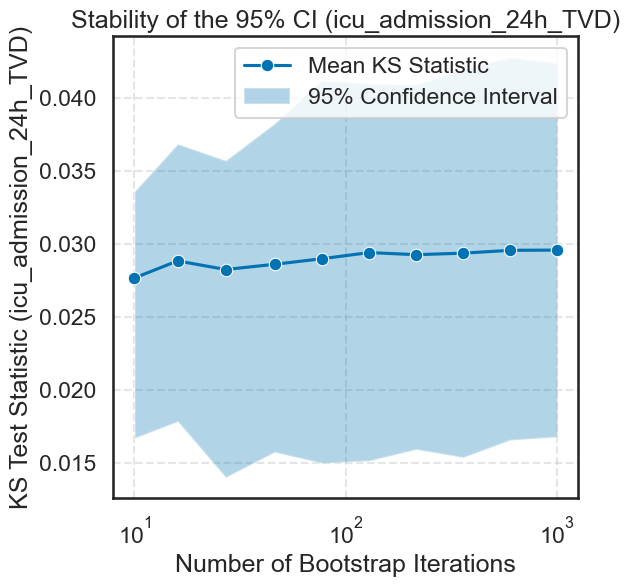

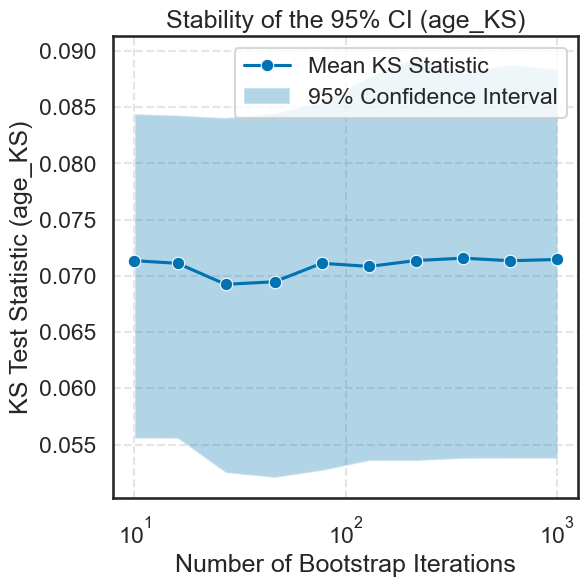

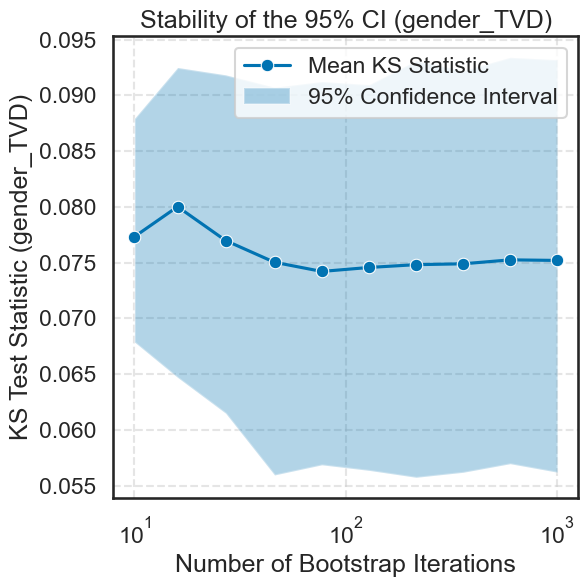

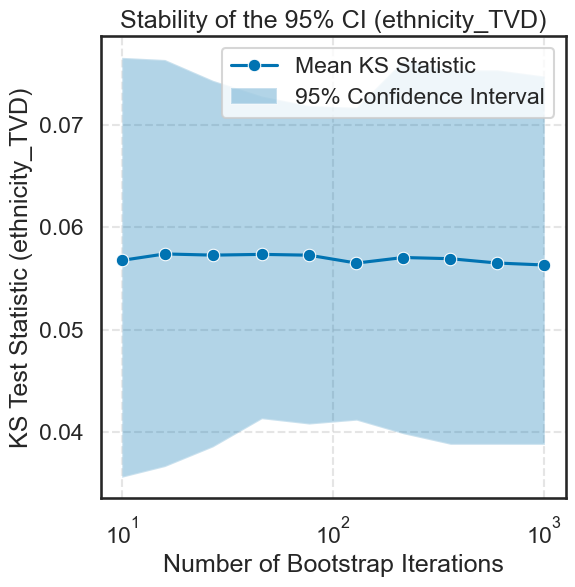

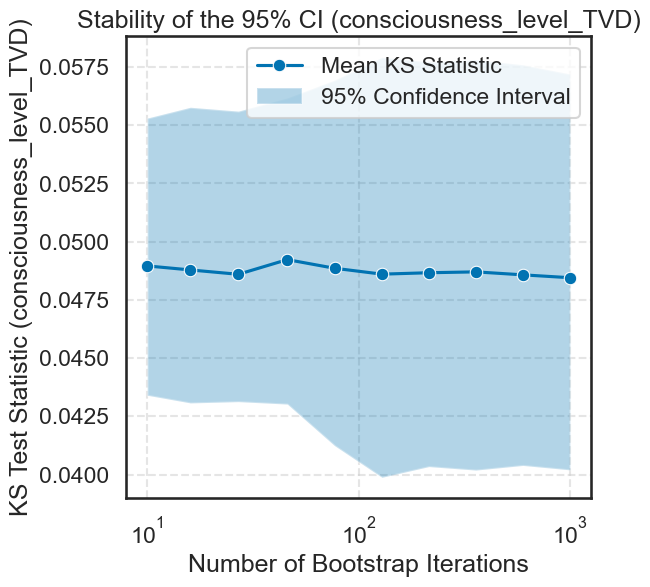

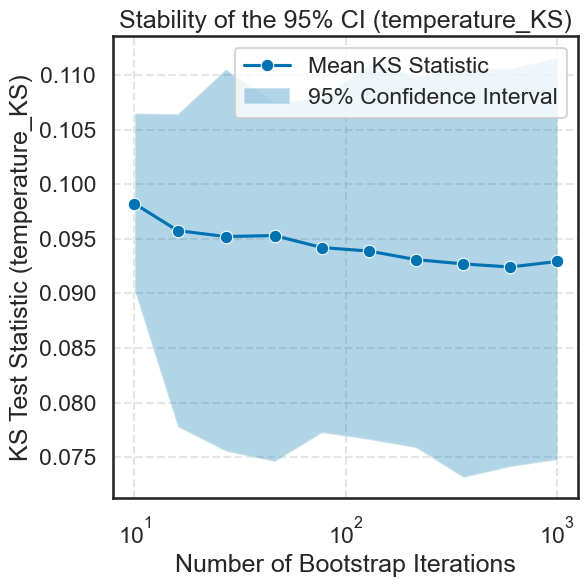

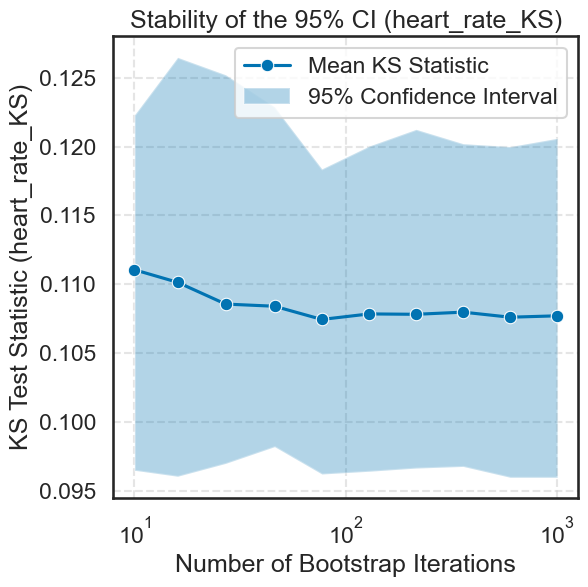

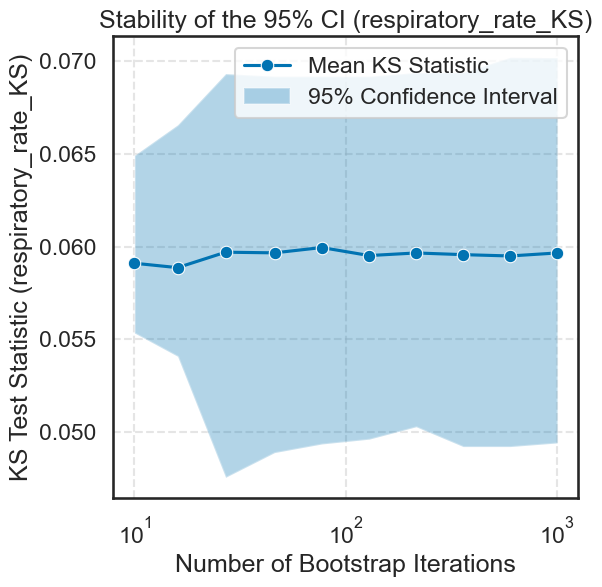

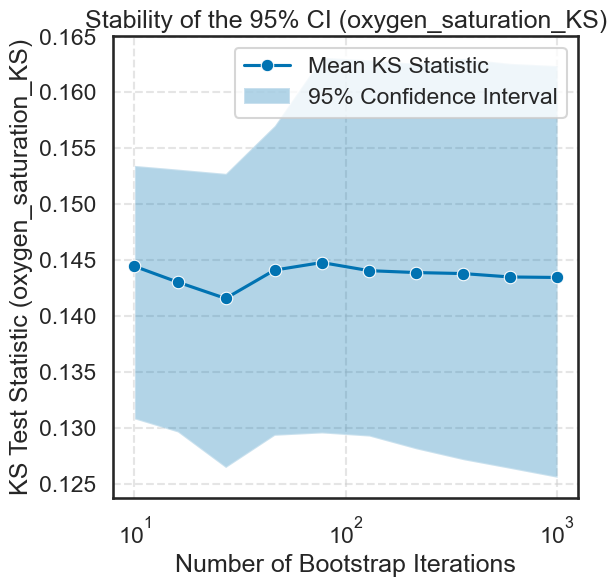

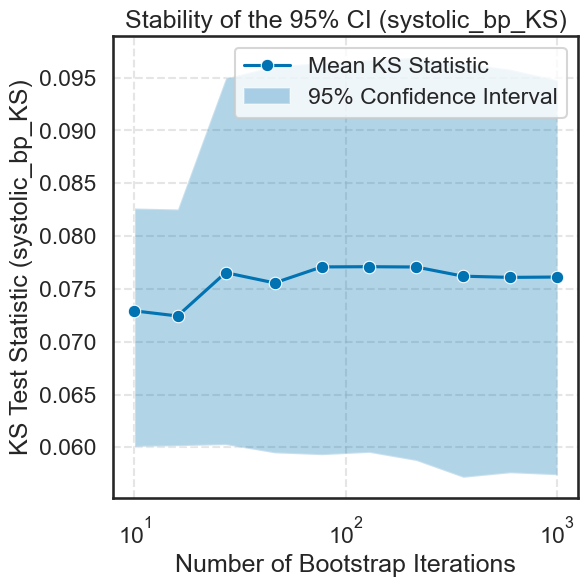

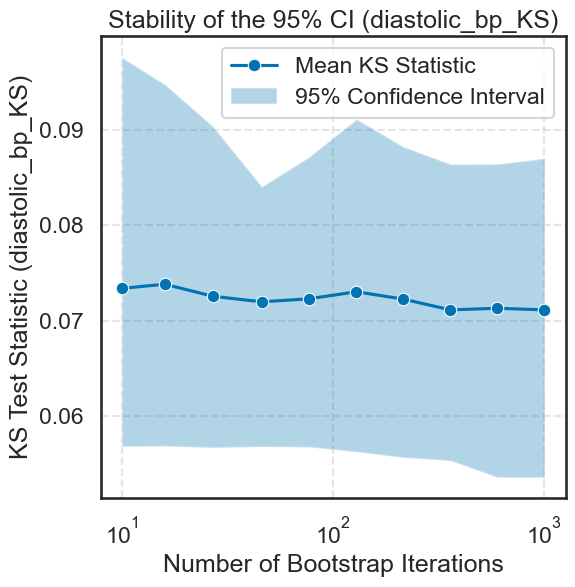

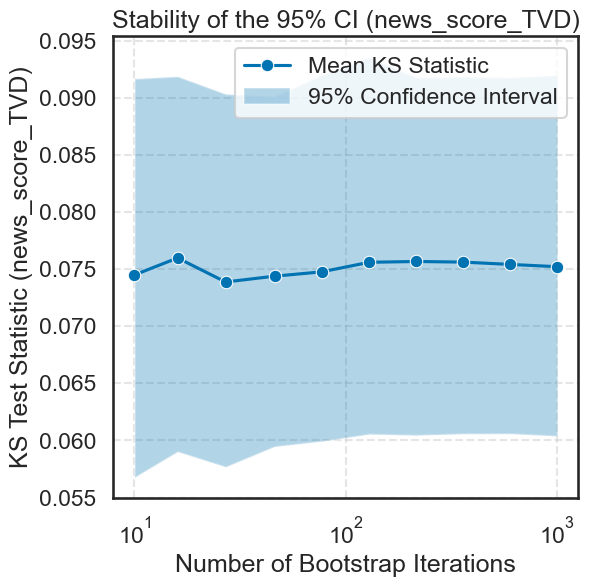

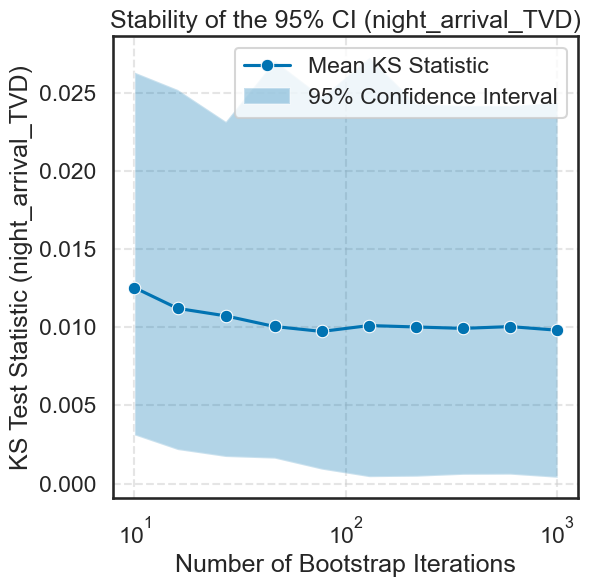

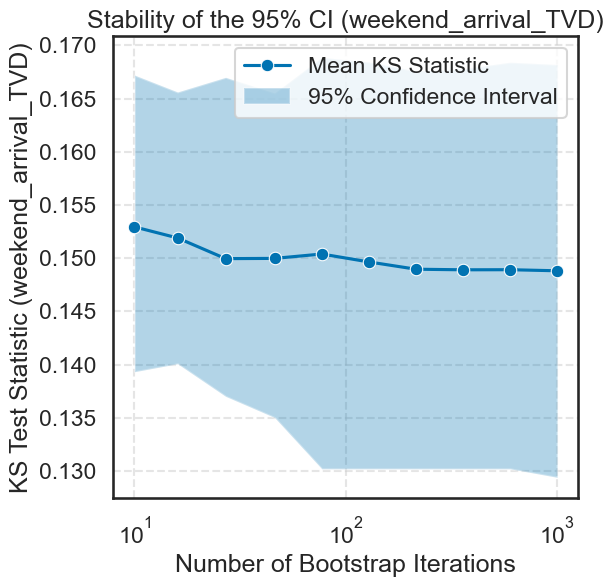

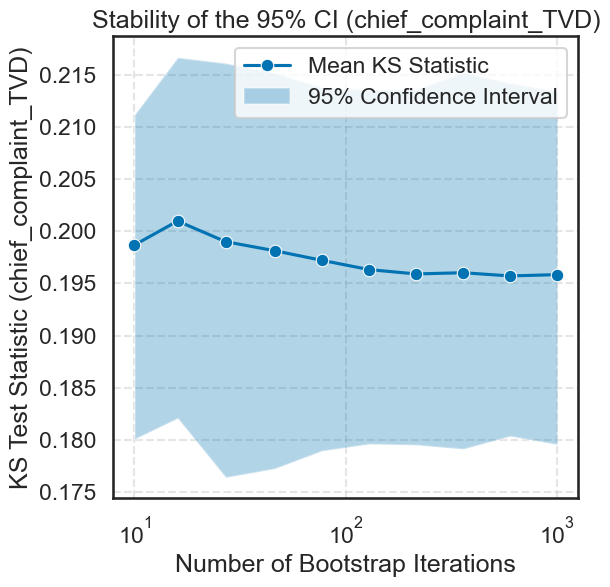

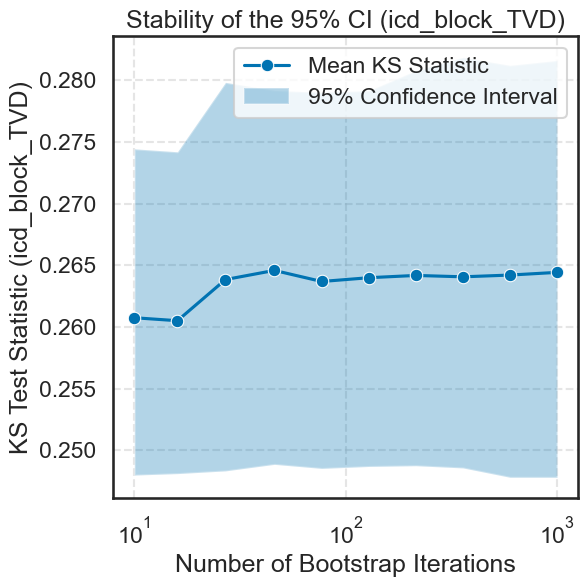

In [46]:
# bootstrap_sizes = np.linspace(10, N_BOOTSTRAP, N_STEPS, dtype=int).tolist()
bootstrap_sizes = np.unique(np.geomspace(10, N_BOOTSTRAP, num=10, dtype=int)).tolist()

# attr = "age"

# --- y axis limits ---
numeric_cols = df_real.select_dtypes(include='number').columns
all_lowers = []
all_uppers = []

for attr in df_real.columns:
# for attr in ['diastolic_bp']:
    if attr in numeric_cols:
        attr += "_KS"
    else:
        attr += "_TVD"
    for n in bootstrap_sizes:
        sample_stats = df_results[attr].iloc[:n]
        all_lowers.append(np.percentile(sample_stats, 2.5))
        all_uppers.append(np.percentile(sample_stats, 97.5))

global_min = min(all_lowers)
global_max = max(all_uppers)
# Optional noch ein bisschen Puffer hinzufügen:
margin = 0.05 * (global_max - global_min)
y_limits = (global_min - margin, global_max + margin)

# --- Plotting ---
for attr in df_real.columns:
# for attr in ['diastolic_bp']:
    if attr in numeric_cols:
        attr += "_KS"
    else:
        attr += "_TVD"
    fig, ax = plot_ci_stability(df_results=df_results, feature_col=attr, bootstrap_sizes=bootstrap_sizes, figsize=(6, 6))
    plt.show()
    if SAVE_FIG:
        output_dir_ci = OUTPUT_DIR_FIG / "KS_CI-Sability"
        output_dir_ci.mkdir(parents=True, exist_ok=True)
        fig.savefig(output_dir_ci / f"ks-test_ci_stability_{attr}_{N_BOOTSTRAP}.tiff", dpi=300, format='tiff', bbox_inches='tight', pil_kwargs={'compression': 'tiff_lzw'})
    plt.close(fig)